# Проект 7. Прогнозирование биологического ответа

Целью данной задачи является построение модели предсказания биологического ответа молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

В качестве метрики использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
import time
import numpy as np
import pandas as pd

from sklearn import linear_model #линейные модели
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials
import optuna

from plotly import graph_objects as go
from plotly.subplots import make_subplots

## Знакомство с данными и их исследование

In [2]:
df_molecules = pd.read_csv('data/_train_sem09 (1).csv')
df_molecules.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Согласно условиям задания предварительная обработка не требуется, данные уже закодированы и нормализованы.

Формирование матрицы наблюдений $X$ и вектора ответов $y$.

In [3]:
X = df_molecules.drop(['Activity'], axis=1)
y = df_molecules['Activity']

Разделение выборки на тренировочную и тестовую в соотношении 80/20 с сохранением соотношений целевого признака (стратифицированное разбиение). 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

---

## Оптимизация гиперпараметров модели

### **Логистическая регрессия**

Формирование baseline-модели логистической регрессии с гиперпараметрами по умолчанию и вычисление ее метрики.

In [5]:
# Словарь метрик моделей логистической регрессии
dict_scores_LR = {}

In [6]:
#Создаем объект класса логистическая регрессия
model_log_reg = linear_model.LogisticRegression(max_iter = 1000, 
                                                random_state=42)
# Время начала
tic = time.time()
#Обучаем модель, минимизируя logloss
model_log_reg.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_log_reg, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_log_reg, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_LR['Base'] = [f1_train, f1_test, toc - tic]

F1-мера на обучающей выборке: 0.774
F1-мера на тестовой выборке: 0.737


При построении модели с использованием гиперпараметров по умолчанию получено значение $F_1-меры$ на тестовой выборке **0.737**, затрачено времени 2.14 секунды.

>Время выполнения будет отличаться при запуске на различных ПК, так как зависит от вычислительной мощности платформы, но данная величина может дать общее представление, если сравнивать этот показатель при использовании различных методов подбора гиперпараметров относительно друг друга.

#### GridSeachCV

Обычно для Logistic Regression гиперпараметр $C$ тестируют в пределах от $10^{−5}$ до $10^5$. Это покрывает широкий диапазон возможных уровней регуляризации. Часто оптимальные значения находятся в пределах $10^{−3}$ до $10^3$, так как задача учебная, возьмем для ее реализации диапазон от $10^{-1}$ до 10. Сочетания типов и алгоритмов регуляризации возьмем также не все, но с отработкой исключения несовместимых параметров.

In [7]:
# Сетка параметров
param_grid = [{'penalty': ['l1', 'l2'], # тип регуляризации
               'solver': ['liblinear'], # алгоритм оптимизации
               'C': [10**i for i in range(-1, 2)]}, # Логарифмическая сетка от 10^-1 до 10
              {'penalty': ['l2', None],
               'solver': ['lbfgs', 'newton-cholesky', 'sag'],
               'C': [10**i for i in range(-1, 2)]},
              {'penalty': ['l1', 'l2', None],
               'solver': ['saga'],
               'C': [10**i for i in range(-1, 2)]}]
# Время начала
tic = time.time()
grid_search_LR = GridSearchCV(estimator=linear_model.LogisticRegression(random_state=42, 
                                                                        max_iter=1000), 
                              param_grid=param_grid,
                              cv=5, # Обучение с использованием кросс-валидации
                              n_jobs=-1)
grid_search_LR.fit(X_train, y_train)
# Время окончания
toc = time.time()

Для объективного сравнения необходима оценка всех моделей по одной схеме. Ввиду особенностей реализации метода получения оценки cross_val_score, а именно итерационного обучения оцениваемой модели, для получения оценок на тестовых данных создаем новую модель с найденными наилучшими значениями гиперпараметров.

In [8]:
#Создаем объект класса логистическая регрессия
model_log_reg_gs = linear_model.LogisticRegression(**grid_search_LR.best_params_,
                                                   max_iter = 1000, 
                                                   random_state=42)
#Обучаем модель, минимизируя logloss
model_log_reg_gs.fit(X_train, y_train)
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_log_reg_gs, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_log_reg_gs, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_LR['GridSearchCV'] = [f1_train, f1_test, toc - tic]
print(f'Наилучшие значения гиперпараметров: {grid_search_LR.best_params_}')

F1-мера на обучающей выборке: 0.786
F1-мера на тестовой выборке: 0.731
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


Полный перебор всех возможных в пространстве параметров сочетаний наиболее затратен по времени. В текущих условиях он составил 51 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.786**, а на тестовой выборке - **0.731**, наилучшими значениями гиперпараметров составили:
- penalty: l2;
- solver: lbfgs;
- С: 0.1.

#### RandomizedSearchCV

In [11]:
# Время начала
tic = time.time()
randomized_search_LR = RandomizedSearchCV(estimator=linear_model.LogisticRegression(random_state=42, 
                                                                                    max_iter=1000), 
                                          param_distributions=param_grid,
                                          n_iter=10,
                                          cv=5, # Обучение с использованием кросс-валидации
                                          n_jobs=-1)
randomized_search_LR.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Применение найденных параметров
model_log_reg_randgs = linear_model.LogisticRegression(**randomized_search_LR.best_params_,
                                                   max_iter = 1000, 
                                                   random_state=42)
#Обучаем модель, минимизируя logloss
model_log_reg_randgs.fit(X_train, y_train)
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_log_reg_randgs, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_log_reg_randgs, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_LR['RandomizedSearchCV'] = [f1_train, f1_test, toc - tic]
print(f'Наилучшие значения гиперпараметров: {randomized_search_LR.best_params_}')

F1-мера на обучающей выборке: 0.786
F1-мера на тестовой выборке: 0.731
Наилучшие значения гиперпараметров: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 0.1}


При подборе гиперпараметров посредством RandomizedSearchCV на 10 итераций с использованием кросс-валидации на 5 фолдах затрачено 14 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.786**, а на тестовой выборке - **0.731**, наилучшими значениями гиперпараметров предлагаются:
- penalty: l2;
- solver: newton-cholesky;
- С: 0.1.  

Значения метрики на тренировочных данных практически те же, что и при полном переборе, при этом времени затрачено почти в четыре раза меньше.

#### Hyperopt

In [12]:
# Определение пространство поиска гиперпараметров
values_penalty = ['l1', 'l2', None]
values_solver = ['liblinear', 'lbfgs', 'newton-cholesky', 'sag', 'saga']
values_C = [10**i for i in range(-3, 4)]
space={'penalty': hp.choice('penalty', values_penalty) , # тип регуляризации
       'solver': hp.choice('solver', values_solver), # алгоритм оптимизации
       'C': hp.choice('C', values_C)}


def is_valid_penalty_solver(penalty, solver):
    """Проверка совместимости penalty и solver"""
    if penalty in ['l1', 'l2'] and solver == 'liblinear':
        return True
    if penalty in ['l2', None] and solver in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']:
        return True
    if penalty in ['elasticnet', 'l1', 'l2', None] and solver == 'saga':
        return True
    return False


# Определение целевой функции
def hyperopt_rf(params, cv=5, X=X_train, y=y_train):
    # Получение комбинации гиперпараметров
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
              'C': float(params['C'])}
    # Проверка совместимости penalty и solver
    if not is_valid_penalty_solver(params['penalty'], params['solver']):
        return 0
    # Построение модели
    model = linear_model.LogisticRegression(**params,
                                            random_state=42, 
                                            max_iter=1000)
    # Обучение модели
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score


trials = Trials() # Логирование результатов
# Время начала
tic = time.time()
best=fmin(hyperopt_rf,
          space=space,
          max_evals=10,
          trials=trials,
          rstate=np.random.default_rng(42))
# Формирование и обучение модели на найденных параметрах
model_lr_hp = linear_model.LogisticRegression(random_state=42,
                                              max_iter=1000,
                                              penalty=values_penalty[int(best['penalty'])],
                                              solver=values_solver[int(best['solver'])],
                                              C=values_C[int(best['C'])])
model_lr_hp.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_lr_hp, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_lr_hp, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_LR['Hyperopt'] = [f1_train, f1_test, toc - tic]
print(f"Наилучшие значения гиперпараметров {values_penalty[int(best['penalty'])],
                                            values_solver[int(best['solver'])],
                                            values_C[int(best['C'])]}")

TPE is being used as the default algorithm.


100%|██████████| 10/10 [07:54<00:00, 47.47s/trial, best loss: -0.7842972882154436]
F1-мера на обучающей выборке: 0.784
F1-мера на тестовой выборке: 0.746
Наилучшие значения гиперпараметров ('l1', 'liblinear', 0.1)


При подборе гиперпараметров посредством Hyperopt на 10 итерациях с использованием кросс-валидации на 5 фолдах затрачено 8 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.784**, а на тестовой выборке - **0.746**, наилучшими значениями гиперпараметров предлагаются:
- penalty: l1;
- solver: liblinear;
- С: 0.1.

#### Optuna

In [13]:
def optuna_rf(trial):
    # Определение пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', values_penalty)
    solver = trial.suggest_categorical('solver', values_solver)
    C = trial.suggest_categorical('C', values_C)
    # Проверка совместимости penalty и solver
    if not is_valid_penalty_solver(penalty, solver):
        return 0
    # Построение модели
    model = linear_model.LogisticRegression(random_state=42,
                                            max_iter=1000,
                                            penalty=penalty,
                                            solver=solver,
                                            C=C)
    # Обучение модели
    model.fit(X_train, y_train)
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
    return score


# Время начала
tic = time.time()
# Объявление объекта исследования
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Поиск лучшей комбинации гиперпараметров
study.optimize(optuna_rf, n_trials=10)
# Формирование и обучение модели на найденных параметрах
model_lr_opt = linear_model.LogisticRegression(**study.best_params,
                                               random_state=42,
                                               max_iter=1000)
model_lr_opt.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_lr_opt, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_lr_opt, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_LR['Optuna'] = [f1_train, f1_test, toc - tic]
print(f"Наилучшие значения гиперпараметров {study.best_params}")

[I 2025-05-11 22:30:56,091] A new study created in memory with name: LogisticRegression
d:\!Works\Projects\sf_data_science_hw\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

d:\!Works\Projects\sf_data_science_hw\.venv\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:576: LinAlgWarning:

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.37632e-23): result may not be accurate.

d:\!Works\Projects\sf_data_science_hw\.venv\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:195: ConvergenceWarning:

lbfgs failed to

F1-мера на обучающей выборке: 0.784
F1-мера на тестовой выборке: 0.746
Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.1}


При подборе гиперпараметров посредством Optuna на 10 итерациях с использованием кросс-валидации на 5 фолдах затрачено 22 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.784**, а на тестовой выборке - **0.746**, наилучшими значениями гиперпараметров предлагаются:
- penalty: l1;
- solver: saga;
- С: 0.1.

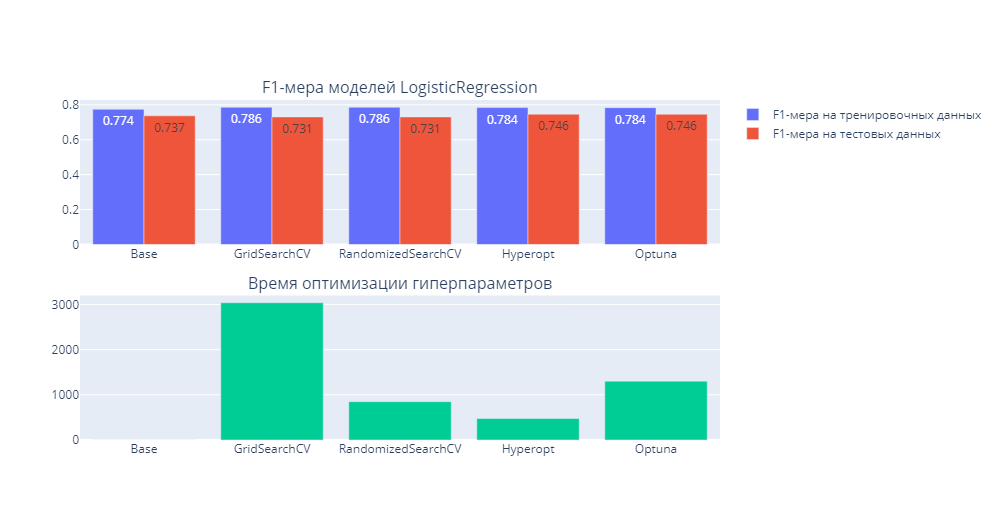

In [14]:
df_show = pd.DataFrame.from_dict(dict_scores_LR, 
                                 columns=['F1_train', 'F1_test', 'Time'],
                                 orient='index')
# Инициализация полотна
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("F1-мера моделей LogisticRegression", 
                                    "Время оптимизации гиперпараметров"),
                    row_heights=[0.5, 0.5],
                    vertical_spacing=0.15)
# Построение баров
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['F1_train'],
                     showlegend=True,
                     text=df_show['F1_train'].round(3),
                     name='F1-мера на тренировочных данных'),
              row=1, col=1)
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['F1_test'],
                     showlegend=True,
                     text=df_show['F1_test'].round(3),
                     name='F1-мера на тестовых данных'),
              row=1, col=1)
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['Time'],
                     showlegend=False,
                     name='Время обучения'),
              row=2, col=1)
# Размер полотна
fig.update_layout(autosize = False, width = 1000, height = 520)
fig.show("png")

Все методы подбора гиперпараметров показывают примерно одинаковые итоговые значения $F_1-меры$ на тренировочных данных, если ориентироваться на метрики на тестовых данных, то лучшие показатели получены при использовании Hyperopt и Optuna, при этом более предпочтительным представляется использование Hyperopt, так как данный метод имеет в своей основе алгоритм TPE, учитывающий предыдущие полученные результаты оценки обучения модели, а не случайный выбор наборов гиперпараметров, при этом времени на подбор параметров затрачено меньше всего.

---

### **Случайный лес**

Формирование baseline-модели случайного леса с гиперпараметрами по умолчанию и вычисление ее метрики.

In [15]:
# Словарь метрик моделей логистической регрессии
dict_scores_RF = {}

In [16]:
#Создаем объект класса логистическая регрессия
model_rf = ensemble.RandomForestClassifier(random_state=42)
# Время начала
tic = time.time()
#Обучаем модель, минимизируя logloss
model_rf.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_rf, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_rf, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_RF['Base'] = [f1_train, f1_test, toc - tic]

F1-мера на обучающей выборке: 0.814
F1-мера на тестовой выборке: 0.739


При построении модели с использованием гиперпараметров по умолчанию получено значение метрики **0.814**, затрачено времени 3.5 секунды.

>Время выполнения будет отличаться при запуске на различных ПК, так как зависит от вычислительной мощности платформы, но данная величина может дать общее представление, если сравнивать этот показатель при использовании различных методов подбора гиперпараметров относительно друг друга.

#### GridSeachCV

Обычно для Logistic Regression гиперпараметр $C$ тестируют в пределах от $10^{−5}$ до $10^5$. Это покрывает широкий диапазон возможных уровней регуляризации. Часто оптимальные значения находятся в пределах $10^{−3}$ до $10^3$, так как задача учебная, возьмем для ее реализации диапазон от $10^{-2}$ до 10.

Сочетания типов и алгоритмов регуляризации возьмем все допустимые.

In [17]:
# Сетка параметров
param_grid = {'n_estimators': list(range(100, 400, 100)),
              'criterion': ['gini', 'entropy'],
              'max_depth': list(range(20, 40, 10)),
              'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': list(range(5, 25, 10))}
# Время начала
tic = time.time()
grid_search_RF = GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42), 
                              param_grid=param_grid,
                              cv=5, # Обучение с использованием кросс-валидации
                              n_jobs=-1)
grid_search_RF.fit(X_train, y_train)
# Время окончания
toc = time.time()

Для объективного сравнения необходима оценка всех моделей по одной схеме. Ввиду особенностей реализации метода получения оценки cross_val_score, а именно итерационного обучения оцениваемой модели, для получения оценок на тестовых данных создаем новую модель с найденными наилучшими значениями гиперпараметров.

In [18]:
#Создаем объект класса логистическая регрессия
model_rf_gs = ensemble.RandomForestClassifier(**grid_search_RF.best_params_,
                                              random_state=42)
#Обучаем модель, минимизируя logloss
model_rf_gs.fit(X_train, y_train)
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_rf_gs, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_rf_gs, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_RF['GridSearchCV'] = [f1_train, f1_test, toc - tic]
print(f'Наилучшие значения гиперпараметров: {grid_search_RF.best_params_}')

F1-мера на обучающей выборке: 0.817
F1-мера на тестовой выборке: 0.746
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


Полный перебор всех возможных в пространстве параметров сочетаний наиболее затратен по времени. В текущих условиях он составил 5 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.817**, а на тестовой выборке - **0.746**, наилучшими значениями гиперпараметров составили:
- n_estimators: 200;
- criterion: entropy;
- max_depth: 30;
- max_features: sqrt;
- min_samples_leaf: 5.

#### RandomizedSearchCV

In [19]:
# Время начала
tic = time.time()
randomized_search_RF = RandomizedSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42), 
                                          param_distributions=param_grid,
                                          n_iter=10,
                                          cv=5, # Обучение с использованием кросс-валидации
                                          n_jobs=-1)
randomized_search_RF.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Применение найденных параметров
model_rf_randgs = ensemble.RandomForestClassifier(**randomized_search_RF.best_params_,
                                                  random_state=42)
#Обучаем модель, минимизируя logloss
model_rf_randgs.fit(X_train, y_train)
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model_rf_randgs, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model_rf_randgs, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_RF['RandomizedSearchCV'] = [f1_train, f1_test, toc - tic]
print(f'Наилучшие значения гиперпараметров: {randomized_search_RF.best_params_}')

F1-мера на обучающей выборке: 0.812
F1-мера на тестовой выборке: 0.752
Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}


При подборе гиперпараметров посредством RandomizedSearchCV на 10 итераций с использованием кросс-валидации на 5 фолдах затрачено 1 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.812**, а на тестовой выборке - **0.752**, наилучшими значениями гиперпараметров предлагаются:
- n_estimators: 100;
- criterion: entropy;
- max_depth: 20;
- max_features: sqrt;
- min_samples_leaf: 5.
Значения метрики те же, что и при полном переборе, но времени затрачено в пять раз меньше.

#### Hyperopt

In [20]:
# Определение пространство поиска гиперпараметров
values_criterion = ['gini', 'entropy']
values_max_features = ['sqrt', 'log2']
space={'n_estimators': hp.quniform('n_estimators', 100, 400, 100),
       'criterion': hp.choice('criterion', values_criterion),
       'max_depth': hp.quniform('max_depth', 20, 40, 10),
       'max_features': hp.choice('max_features', values_max_features),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 25, 10)}


# Определение целевой функции
def hyperopt_rf(params, cv=5, X=X_train, y=y_train):
    # Получение комбинации гиперпараметров
    params = {'n_estimators': int(params['n_estimators']),
              'criterion': str(params['criterion']),
              'max_depth': int(params['max_depth']),
              'max_features': str(params['max_features']),
              'min_samples_leaf': int(params['min_samples_leaf'])}
    # Построение модели
    model = ensemble.RandomForestClassifier(**params,
                                            random_state=42)
    # Обучение модели
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score


trials = Trials() # Логирование результатов
# Время начала
tic = time.time()
best=fmin(hyperopt_rf,
          space=space,
          max_evals=10,
          trials=trials,
          rstate=np.random.default_rng(42))
# Формирование и обучение модели на найденных параметрах
model = ensemble.RandomForestClassifier(random_state=42,
                                        criterion=values_criterion[int(best['criterion'])],
                                        n_estimators=int(best['n_estimators']),
                                        max_depth=int(best['max_depth']),
                                        max_features=values_max_features[int(best['max_features'])],
                                        min_samples_leaf=int(best['min_samples_leaf']))
model.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_RF['Hyperopt'] = [f1_train, f1_test, toc - tic]
print(f"Наилучшие значения гиперпараметров {best,
                                            values_criterion[int(best['criterion'])],
                                            values_max_features[int(best['max_features'])]}")

TPE is being used as the default algorithm.


100%|██████████| 10/10 [01:17<00:00,  7.73s/trial, best loss: -0.8026970674798166]
F1-мера на обучающей выборке: 0.803
F1-мера на тестовой выборке: 0.754
Наилучшие значения гиперпараметров ({'criterion': np.int64(0), 'max_depth': np.float64(30.0), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(10.0), 'n_estimators': np.float64(300.0)}, 'gini', 'sqrt')


При подборе гиперпараметров посредством Hyperopt на 10 итерациях с использованием кросс-валидации на 5 фолдах затрачено 1 мин. 23 сек.
При этом на тренировочной выборке получена $F_1-мера$ **0.803**, а на тестовой выборке - **0.754**, наилучшими значениями гиперпараметров предлагаются:
- n_estimators: 300;
- criterion: gini;
- max_depth: 30;
- max_features: sqrt;
- min_samples_leaf: 10.

#### Optuna

In [21]:
def optuna_rf(trial):
    # Определение пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 400, step=100)
    criterion = trial.suggest_categorical('criterion', values_criterion)
    max_depth = trial.suggest_int('max_depth', 20, 40, step=10)
    max_features = trial.suggest_categorical('max_features', values_max_features)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 25, step=10)
    
    # Построение модели
    model = ensemble.RandomForestClassifier(random_state=42,
                                            criterion=criterion,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            max_features=max_features,
                                            min_samples_leaf=min_samples_leaf)
    # Обучение модели
    model.fit(X_train, y_train)
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
    return score


# Время начала
tic = time.time()
# Объявление объекта исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Поиск лучшей комбинации гиперпараметров
study.optimize(optuna_rf, n_trials=10)
# Формирование и обучение модели на найденных параметрах
model = ensemble.RandomForestClassifier(**study.best_params,
                                        random_state=42)
model.fit(X_train, y_train)
# Время окончания
toc = time.time()
# Вычисление метрик и их фиксация для анализа
f1_train = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на обучающей выборке: {f1_train:.3f}')
f1_test = cross_val_score(model, X_test, y_test, cv=5, scoring="f1", n_jobs=-1).mean()
print(f'F1-мера на тестовой выборке: {f1_test:.3f}')
dict_scores_RF['Optuna'] = [f1_train, f1_test, toc - tic]
print(f"Наилучшие значения гиперпараметров {study.best_params}")

[I 2025-05-11 23:03:07,698] A new study created in memory with name: RandomForestClassifier
[I 2025-05-11 23:03:18,158] Trial 0 finished with value: 0.7530034610806748 and parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 25}. Best is trial 0 with value: 0.7530034610806748.
[I 2025-05-11 23:03:30,234] Trial 1 finished with value: 0.7796206102582914 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 25}. Best is trial 1 with value: 0.7796206102582914.
[I 2025-05-11 23:03:42,064] Trial 2 finished with value: 0.7796206102582914 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 25}. Best is trial 1 with value: 0.7796206102582914.
[I 2025-05-11 23:04:14,170] Trial 3 finished with value: 0.8098831829857843 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20, 'max_f

F1-мера на обучающей выборке: 0.815
F1-мера на тестовой выборке: 0.747
Наилучшие значения гиперпараметров {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5}


При подборе гиперпараметров посредством Optuna на 10 итерациях с использованием кросс-валидации на 5 фолдах затрачено 3 мин.
При этом на тренировочной выборке получена $F_1-мера$ **0.815**, а на тестовой выборке - **0.747**, наилучшими значениями гиперпараметров предлагаются:
- n_estimators: 300;
- criterion: entropy;
- max_depth: 20;
- max_features: sqrt;
- min_samples_leaf: 5.

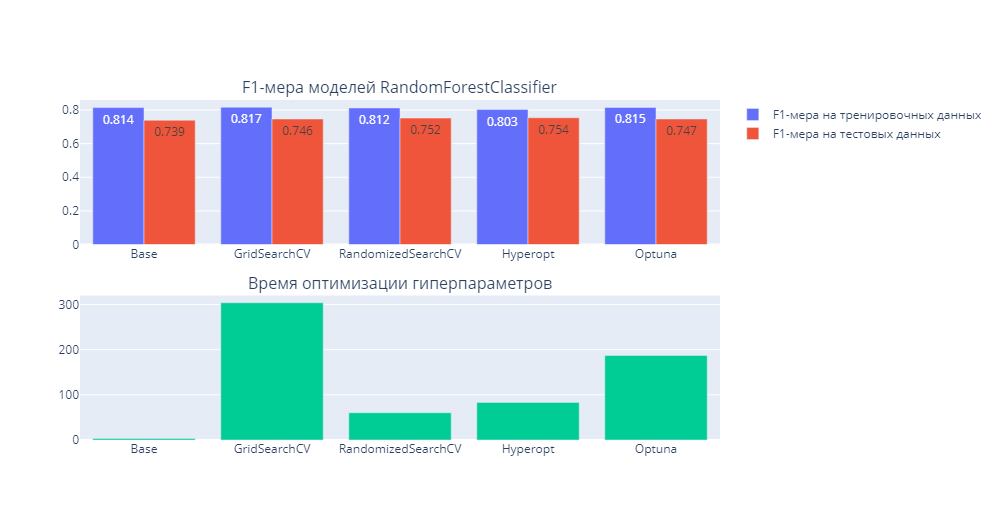

In [22]:
df_show = pd.DataFrame.from_dict(dict_scores_RF, 
                                 columns=['F1_train', 'F1_test', 'Time'],
                                 orient='index')
# Инициализация полотна
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("F1-мера моделей RandomForestClassifier", 
                                    "Время оптимизации гиперпараметров"),
                    row_heights=[0.5, 0.5],
                    vertical_spacing=0.15)
# Построение баров
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['F1_train'],
                     showlegend=True,
                     text=df_show['F1_train'].round(3),
                     name='F1-мера на тренировочных данных'),
              row=1, col=1)
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['F1_test'],
                     showlegend=True,
                     text=df_show['F1_test'].round(3),
                     name='F1-мера на тестовых данных'),
              row=1, col=1)
fig.add_trace(go.Bar(x=df_show.index,
                     y=df_show['Time'],
                     showlegend=False,
                     name='Время обучения'),
              row=2, col=1)
# Размер полотна
fig.update_layout(autosize = False, width = 1000, height = 520)
fig.show("png")

Все методы подбора гиперпараметров показывают примерно одинаковые итоговые значения $F_1-меры$ на тестовых данных, если ориентироваться на время поиска, то лучшие показатели получены при использовании Hyperopt и RandomizedSearchCV, при этом более предпочтительным представляется использование Hyperopt, так как данный метод имеет в своей основе алгоритм TPE, учитывающий предыдущие полученные результаты оценки обучения модели, а не случайный выбор наборов гиперпараметров. При этом гиперпараметры, полученные с использованием библиотеки Hyperopt показывают наилучшее значение метрики на тестовых данных и минимальную из представленных разницу между метриками на тренировочных и тестовых данных, что говорит о минимальной степени переобученности полученной модели среди полученных.

---

>***Общий вывод:*** Рассмотренные методы подбора гиперпараметров представляют собой достаточно мощные инструменты оптимизации. Hyperopt и Optuna наиболее предпочтительны в использовании с точки зрения эффективного использования времени, при этом в качестве подбора гиперпараметров базовой модели можно использовать RanomizedSearchCV. Полный перебор всех возможных вариантов гиперпараметров целесообразно использовать либо при наличии большого количества времени, либо уже после сужения сетки гиперпараметров другими методами.